### import modules

In [1]:
import src.pre_processing as pp
import src.plots as plts
import src.VaeA as vA

import numpy as np
import matplotlib.pyplot as plt

import os

from src.Resnet18 import ResNet18Binary, fine_tune_resnet, evaluate_resnet

### resize images to 128x128

In [2]:
X, Y, Z, proba = pp.get_data()

### Split train, validation, test

In [3]:
X_train, Y_train, Z_train, X_val, Y_val, Z_val, X_test, Y_test, Z_test = pp.split_data(X, Y, Z)

In [4]:
X_train.shape, X_val.shape, X_test.shape

((2099, 128, 128), (262, 128, 128), (263, 128, 128))

## Geometric Augmentation

In [5]:
X_train_aug, Y_train_aug, Z_train_aug = pp.augment_data(X_train, Y_train, Z_train)

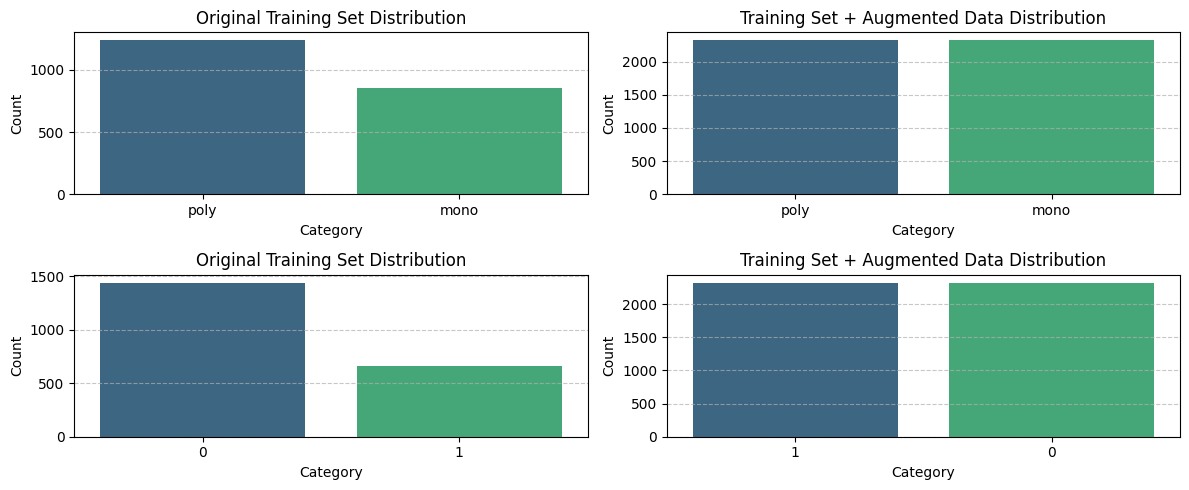

In [6]:
# compare the training set and the training + augmented set distributions
# first concatenate the original and augmented data
X_train_combined = np.concatenate((X_train, X_train_aug), axis=0)
Y_train_combined = np.concatenate((Y_train, Y_train_aug), axis=0)
Z_train_combined = np.concatenate((Z_train, Z_train_aug), axis=0)
fig, axs = plt.subplots(2, 2, figsize=(12, 5))
plts.plot_distribution(Z_train, 'Original Training Set Distribution', axs[0,0])
plts.plot_distribution(Z_train_combined, 'Training Set + Augmented Data Distribution', axs[0,1])
plts.plot_distribution(Y_train, 'Original Training Set Distribution', axs[1,0])
plts.plot_distribution(Y_train_combined, 'Training Set + Augmented Data Distribution', axs[1,1])
plt.tight_layout()
plt.show()

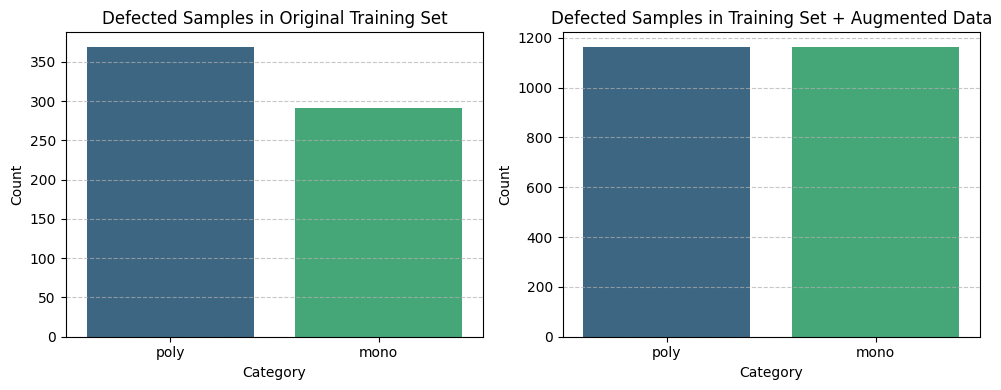

In [7]:
# among the defected samples Y=1 plot the distribution Z=mono Z=poly
Z_train_defected = Z_train[Y_train == 1]
Z_train_combined_defected = Z_train_combined[Y_train_combined == 1]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plts.plot_distribution(Z_train_defected, 'Defected Samples in Original Training Set', axs[0])
plts.plot_distribution(Z_train_combined_defected, 'Defected Samples in Training Set + Augmented Data', axs[1])
plt.tight_layout()
plt.show() 

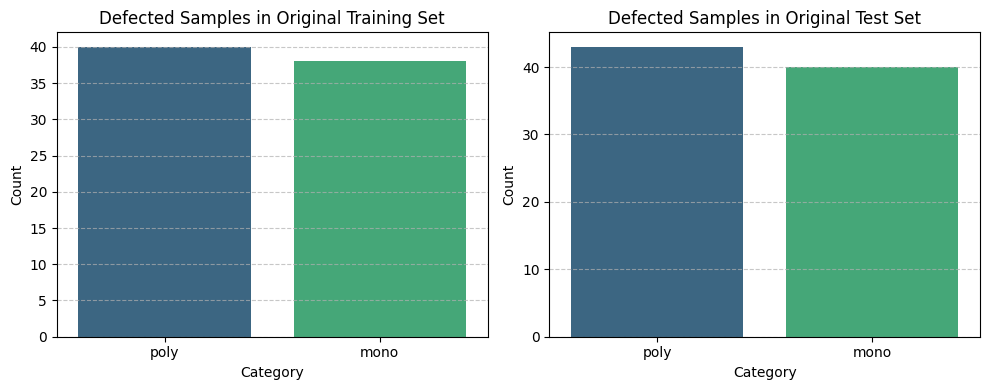

In [8]:
# among the defected samples Y=1 plot the distribution Z=mono Z=poly
Z_val_defected = Z_val[Y_val == 1]
Z_test_defected = Z_test[Y_test == 1]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plts.plot_distribution(Z_val_defected, 'Defected Samples in Original Training Set', axs[0])
plts.plot_distribution(Z_test_defected, 'Defected Samples in Original Test Set', axs[1])
plt.tight_layout()
plt.show() 

## VAE Augmentation

the best VAE is the A with latent dimension of 128, trained with no weigh decay, $\beta$ annealing approach, MSE as reconstruction loss.


To generate data (and to train VAE) we need to separate the defect examples

In [9]:
X_train_aug, Y_train_aug, Z_train_aug = pp.augment_data(X_train, Y_train, Z_train)

X_train_combined = np.concatenate((X_train, X_train_aug), axis=0)
Y_train_combined = np.concatenate((Y_train, Y_train_aug), axis=0)
Z_train_combined = np.concatenate((Z_train, Z_train_aug), axis=0)

X_train_vae = pp.get_defect(X_train_combined,Y_train_combined)
X_val_vae = pp.get_defect(X_val,Y_val)
X_test_vae = pp.get_defect(X_test,Y_test)

Z_train_vae = pp.get_defect(Z_train_combined,Y_train_combined)

Load the weights download it on google drive: https://drive.google.com/drive/folders/1rCzs0FLY0nW0CQRnHPsKPAmqpXf9Uzdv?usp=drive_link

In [10]:
import torch
# Initialize the model architecture first
path = 'vaeA_model_Beta_ann_weights.pth'
model = vA.VAE(latent_dim=128, img_channels=1)
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model.eval() # Set to evaluation mode

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (fc_mu): Linear(in_features=16384, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=16384, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=16384, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (

In [11]:
# creazione dataset dei difettosi del variational autoencoder

X_healthy = X_train_combined[Y_train_combined==0]
X_gen = vA.generate_controlled_samples(model, X_train_vae, Z_train_vae, X_healthy ,n_samples=800, mode='spherical', threshold=9.0, device="cpu")
Y_gen = np.ones(X_gen.shape[0])

Calculating Healthy Centroid...
Centroid calculated. Filtering samples with Latent Distance < 9.0
Generated 100/800 images...
Generated 200/800 images...
Generated 300/800 images...
Generated 400/800 images...
Generated 500/800 images...
Generated 600/800 images...
Generated 700/800 images...
Generated 800/800 images...


## visualize generated images 

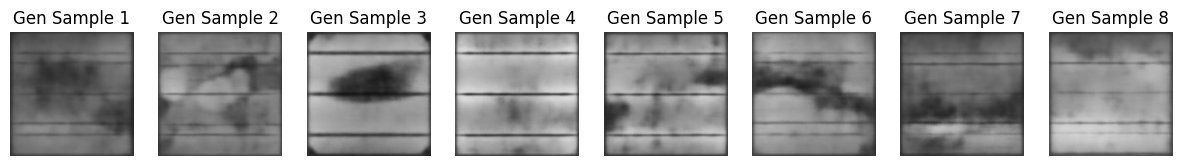

In [12]:
import random
i = random.randint(0, 200)
plts.visualize_augmentations(X_gen[i:,:,:], n_show=8)

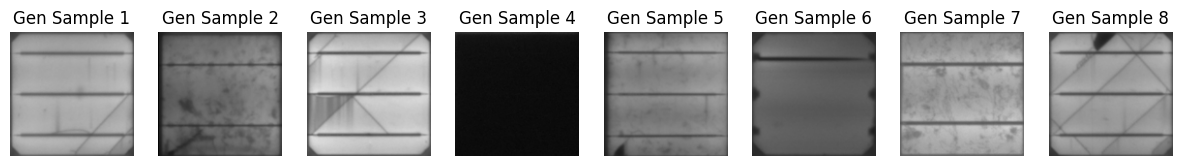

In [13]:
import random
i = random.randint(0, 700)
plts.visualize_augmentations(X_train_vae[i:,:,:], n_show=8)

## visualize interpolation

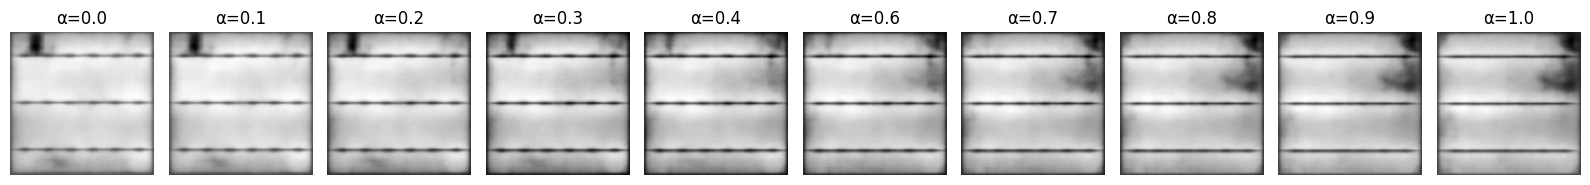

In [14]:
plts.visualize_interpolation(model, X_train_vae, n_steps=10, t=15)

# Final Training Scenarios

In [15]:
X_train, Y_train, Z_train, X_val, Y_val, Z_val, X_test, Y_test, Z_test = pp.split_data(X, Y, Z)

### (1) UNBALANCED 


In [16]:
X_train_1 = X_train
Y_train_1 = Y_train

### (2) UNBALANCED + GEOMETRIC AUGMENTATION

In [17]:
X_train_2 = np.concatenate((X_train, X_train_aug), axis=0)
Y_train_2 = np.concatenate((Y_train, Y_train_aug), axis=0)

### (3) UNBALANCED + VAE AUGMENTATION

In [18]:
X_train_3 = np.concatenate((X_train, X_gen), axis=0)
Y_train_3 = np.concatenate((Y_train, Y_gen), axis=0)

#### See how also with the scenario 3 balance dataset

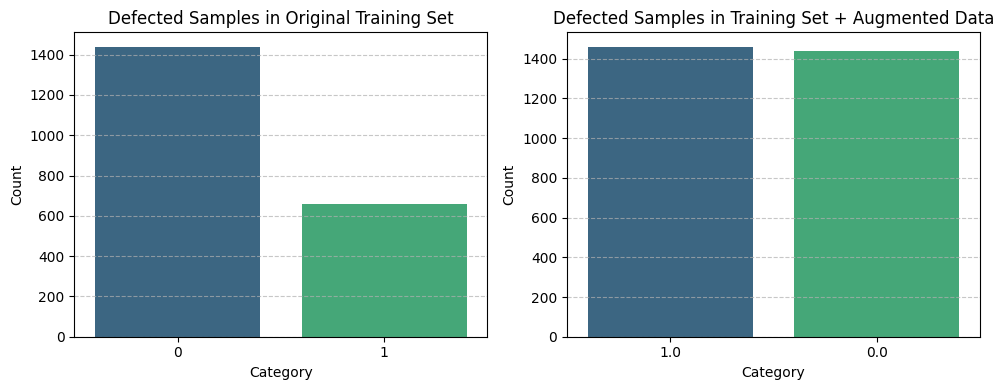

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plts.plot_distribution(Y_train, 'Defected Samples in Original Training Set', axs[0])
plts.plot_distribution(Y_train_gen, 'Defected Samples in Training Set + Augmented Data', axs[1])
plt.tight_layout()
plt.show() 

# ResNet Results

In [19]:
# SETUP FOR EVALUATION (Run this if you skipped the training cell)
# This cell defines the scenarios and checks if the pre-trained weights exist.

if not os.path.exists('models'):
    os.makedirs('models')

# Define scenarios using the datasets prepared earlier
scenarios = [
    ("Unbalanced", X_train_1, Y_train_1, "models/resnet_unbalanced.pth"),
    ("Geometric", X_train_2, Y_train_2, "models/resnet_geometric.pth"),
    ("VAE", X_train_3, Y_train_3, "models/resnet_vae.pth")
]

# Verify that weights exist
print("Checking for saved weights...")
for name, _, _, save_path in scenarios:
    if os.path.exists(save_path):
        print(f" Found weights for {name}: {save_path}")
    else:
        print(f"MISSING weights for {name}: {save_path}")
        print(f"   Please ensure the file is in the 'models' folder or run the training cell.")

Checking for saved weights...
 Found weights for Unbalanced: models/resnet_unbalanced.pth
 Found weights for Geometric: models/resnet_geometric.pth
 Found weights for VAE: models/resnet_vae.pth



=== FINAL TEST SET EVALUATION ===

Evaluating: Unbalanced
Loaded weights from models/resnet_unbalanced.pth
Test Metrics (Unbalanced) - Accuracy: 0.8707, F1: 0.7952, Recall: 0.7952, Precision: 0.7952


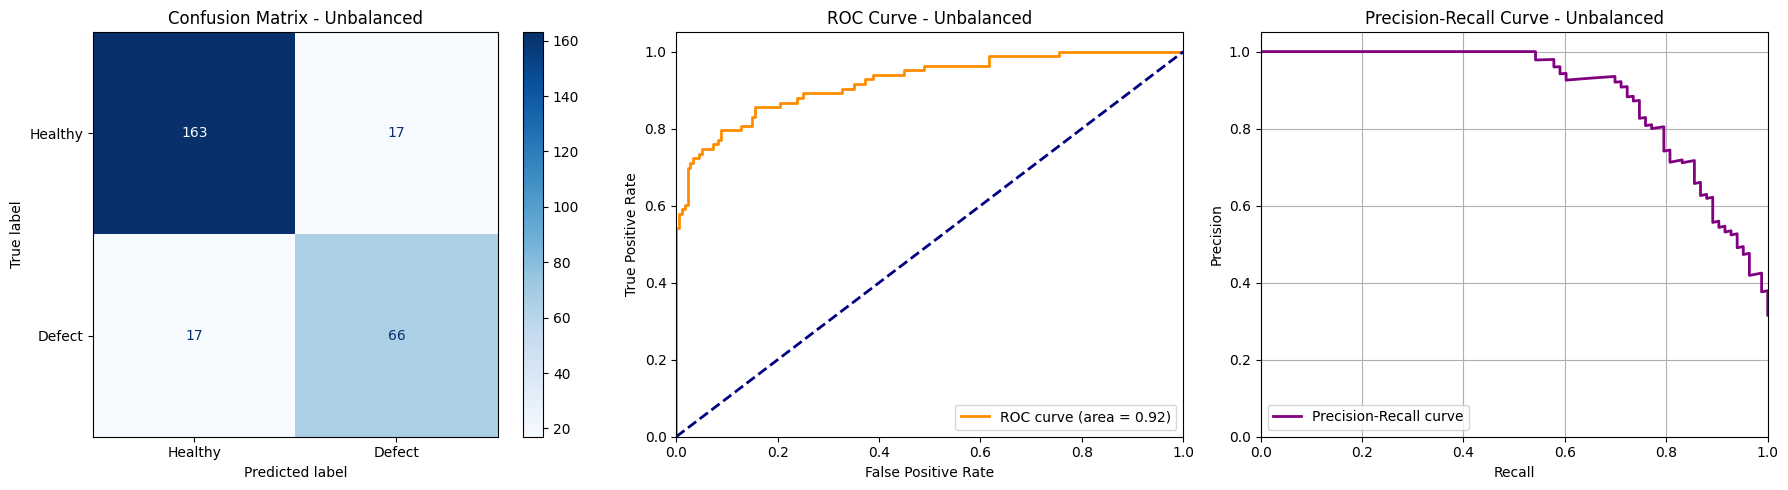


Evaluating: Geometric
Loaded weights from models/resnet_geometric.pth
Test Metrics (Geometric) - Accuracy: 0.8783, F1: 0.8140, Recall: 0.8434, Precision: 0.7865


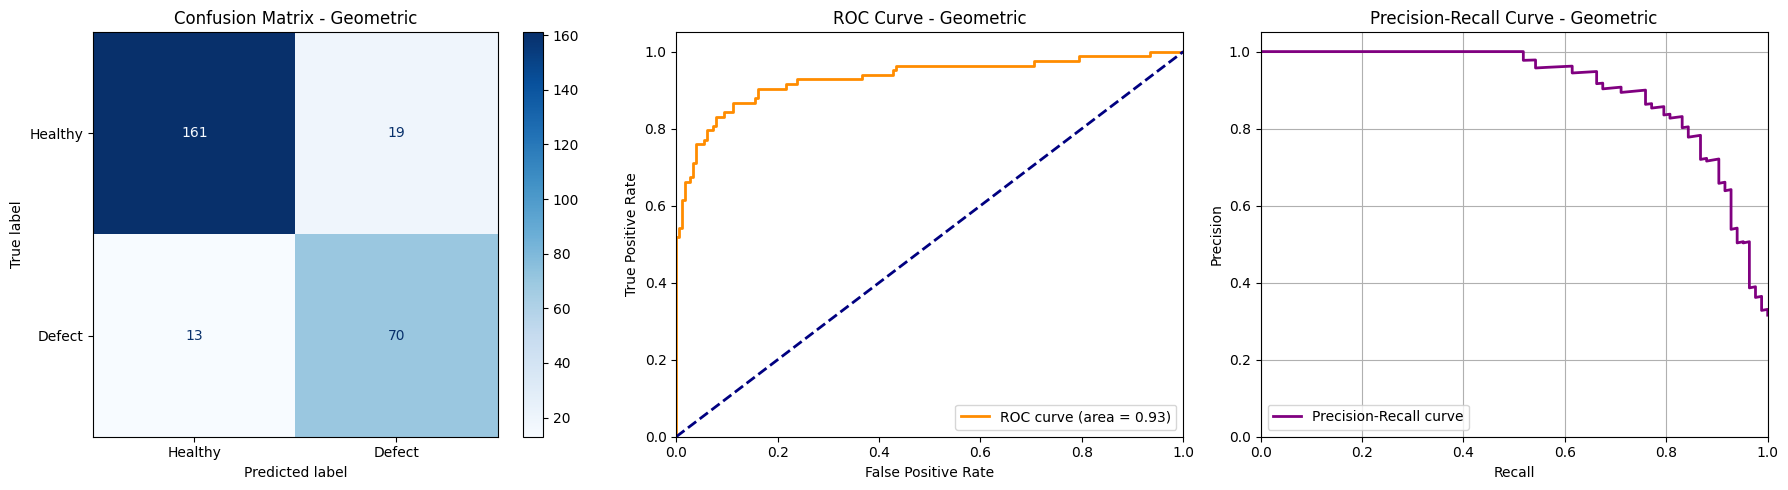


Evaluating: VAE
Loaded weights from models/resnet_vae.pth
Test Metrics (VAE) - Accuracy: 0.8593, F1: 0.7643, Recall: 0.7229, Precision: 0.8108


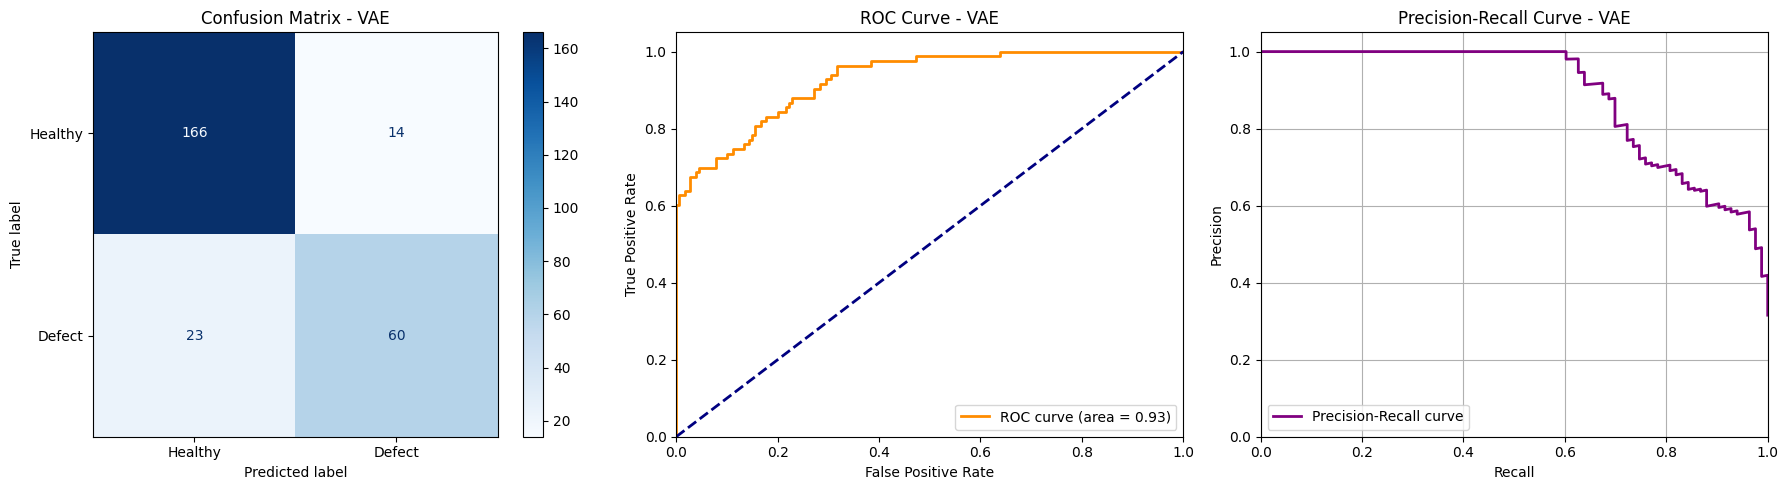

In [20]:
import importlib
import src.Resnet18
importlib.reload(src.Resnet18)
from src.Resnet18 import ResNet18Binary, evaluate_resnet

# Evaluate each saved model on the Test Set
print("\n=== FINAL TEST SET EVALUATION ===")

for name, _, _, save_path in scenarios:
    print(f"\nEvaluating: {name}")
    
    # Load model architecture
    model = ResNet18Binary(pretrained=True)
    
    # Load saved weights
    try:
        model.load_state_dict(torch.load(save_path))
        print(f"Loaded weights from {save_path}")
    except FileNotFoundError:
        print(f"Could not find weights at {save_path}. Did you run the training cell?")
        continue
        
    # Calculate Metrics and Plot using the updated function from Resnet18.py
    # Now includes Precision-Recall Curve
    metrics = evaluate_resnet(model, X_test, Y_test, plot_results=True, model_name=name)